In [1]:
# Init, specify annotation target, load pre-computed lcap, scap, ... tables
%run ~/relmapping/annot/notebooks/annot__init__.ipynb

#annot_ = 'annot_ce10'
annot_ = 'annot_mapq0_ce10'
print('annotation target: %s' % (annot_,))

def mp(fp, annot_=annot_): return os.path.join(annot_, 'metrics_scap', fp)

if annot_ == 'annot_ce10':
    df_atac = pd.read_csv(os.path.join(annot_, 'accessible_sites.tsv'), sep='\t')
    l_atac_peak_pos = df_atac[['start', 'end']].mean(axis=1).map(int)
    df_lcap_fwd = pd.read_csv(os.path.join(annot_, 'metrics_lcap', 'lcap_all_fwd.tsv'), sep='\t', low_memory=False)
    df_lcap_rev = pd.read_csv(os.path.join(annot_, 'metrics_lcap', 'lcap_all_rev.tsv'), sep='\t', low_memory=False)
    df_exon_fwd = pd.read_csv(os.path.join(annot_, 'metrics_exon', 'closest_exon_fwd.tsv'), sep='\t', low_memory=False)
    df_exon_rev = pd.read_csv(os.path.join(annot_, 'metrics_exon', 'closest_exon_rev.tsv'), sep='\t', low_memory=False)
    df_maxgap_fwd = pd.read_csv(os.path.join(annot_, 'metrics_maxgap', 'maxgap_fwd.tsv'), sep='\t')
    df_maxgap_rev = pd.read_csv(os.path.join(annot_, 'metrics_maxgap', 'maxgap_rev.tsv'), sep='\t')
    df_scap_fwd = pd.read_csv(os.path.join(annot_, 'metrics_scap', 'scap_fwd.tsv'), sep='\t')
    df_scap_rev = pd.read_csv(os.path.join(annot_, 'metrics_scap', 'scap_rev.tsv'), sep='\t')

elif annot_ == 'annot_mapq0_ce10':
    df_atac = pd.read_csv(os.path.join('annot_ce10', 'accessible_sites.tsv'), sep='\t')
    l_atac_peak_pos = df_atac[['start', 'end']].mean(axis=1).map(int)
    df_lcap_fwd = pd.read_csv(os.path.join(annot_, 'metrics_lcap', 'lcap_all_fwd.tsv'), sep='\t', low_memory=False)
    df_lcap_rev = pd.read_csv(os.path.join(annot_, 'metrics_lcap', 'lcap_all_rev.tsv'), sep='\t', low_memory=False)
    df_exon_fwd = pd.read_csv(os.path.join('annot_ce10', 'metrics_exon', 'closest_exon_fwd.tsv'), sep='\t', low_memory=False)
    df_exon_rev = pd.read_csv(os.path.join('annot_ce10', 'metrics_exon', 'closest_exon_rev.tsv'), sep='\t', low_memory=False)
    df_maxgap_fwd = pd.read_csv(os.path.join(annot_, 'metrics_maxgap', 'maxgap_fwd.tsv'), sep='\t')
    df_maxgap_rev = pd.read_csv(os.path.join(annot_, 'metrics_maxgap', 'maxgap_rev.tsv'), sep='\t')
    df_scap_fwd = pd.read_csv(os.path.join(annot_, 'metrics_scap', 'scap_fwd.tsv'), sep='\t')
    df_scap_rev = pd.read_csv(os.path.join(annot_, 'metrics_scap', 'scap_rev.tsv'), sep='\t')

else:
    assert False

df_prom_fwd = df_atac[['chrom', 'start', 'end']].copy()
df_prom_rev = df_atac[['chrom', 'start', 'end']].copy()
df_prom_fwd['strand'] = '+'
df_prom_rev['strand'] = '-'

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping
annotation target: annot_mapq0_ce10


In [2]:
# df_pass1_gene_%strand: WS260_ce10 gene coordinates, excluding 250bp downstream of TSS
df_ = pd.concat([
    yp.read_wbgtf('WS260_ce10/WS260_ce10.genes.pseudogene.gtf.gz', parse_attr=True, coords_adj=True),
    yp.read_wbgtf('WS260_ce10/WS260_ce10.genes.protein_coding.gtf.gz', parse_attr=True, coords_adj=True),
], axis=0)

df_pass1_gene_fwd = df_.query('strand == "+"').reset_index(drop=True)[['chrom', 'start', 'end', 'gene_id']]
df_pass1_gene_rev = df_.query('strand == "-"').reset_index(drop=True)[['chrom', 'start', 'end', 'gene_id']]

print(len(df_pass1_gene_fwd), len(df_pass1_gene_rev), 'fwd/rev genes')

# do not mask 250bp downstream of TSS
df_pass1_gene_fwd['start'] = df_pass1_gene_fwd['start'] + 250
df_pass1_gene_rev['end'] = df_pass1_gene_rev['end'] - 250

df_pass1_gene_fwd = df_pass1_gene_fwd.query('start < end')
df_pass1_gene_rev = df_pass1_gene_rev.query('start < end')
print(len(df_pass1_gene_fwd), len(df_pass1_gene_rev), 'fwd/rev genes longer than 250bp kept')

11073 10928 fwd/rev genes
10829 10668 fwd/rev genes longer than 250bp kept


In [3]:
# df_pass1_gpos_%strand[gene_chrom/start/end]: closest gene; if overlaps multiple genes, choose one with the more distal TSS
def df_pos():
    l_atac_peak_pos = df_atac[['start', 'end']].mean(axis=1).map(int)
    df_ = pd.concat([df_atac['chrom'], l_atac_peak_pos, l_atac_peak_pos + 1], axis=1).copy()
    df_.columns = ['chrom', 'start', 'end']
    return df_

def df_closest_(df_a, df_b, b_prefix, **kwargs):
    df_a_sort = df_a
    df_b_sort = df_b.sort_values(list(df_b.columns[:3]))
    fn_ = BedTool.from_dataframe(df_a).closest(BedTool.from_dataframe(df_b_sort).fn, **kwargs).fn
    names_ = list(itertools.chain(df_a.columns.values,
        ['%s_%s' % (b_prefix, col) for col in df_b.columns.values],
    ))
    df_ = pd.read_csv(fn_, sep='\t', names=names_)
    return df_#[names_[len(df_a.columns):]]

df_pass1_gpos_fwd_ = df_closest_(df_pos(), df_pass1_gene_fwd, 'pass1_gpos', t='all')
df_pass1_gpos_rev_ = df_closest_(df_pos(), df_pass1_gene_rev, 'pass1_gpos', t='all')
print(len(df_pass1_gpos_fwd_), len(df_pass1_gpos_rev_), 'fwd/rev gene body hits')

42265 42309 fwd/rev gene body hits


In [4]:
# df_pass1_gpos_%strand[is_nearly_intergenic]: site is outside of gene bodies, or up to 250bp from the TSS
df_pass1_gpos_fwd_['is_nearly_intergenic'] = ~((df_pass1_gpos_fwd_['pass1_gpos_start'] <= df_pass1_gpos_fwd_['start'])\
                                           & (df_pass1_gpos_fwd_['end'] <= df_pass1_gpos_fwd_['pass1_gpos_end']))
df_pass1_gpos_rev_['is_nearly_intergenic'] = ~((df_pass1_gpos_rev_['pass1_gpos_start'] <= df_pass1_gpos_rev_['start'])\
                                           & (df_pass1_gpos_rev_['end'] <= df_pass1_gpos_rev_['pass1_gpos_end']))

l_ = 'is_nearly_intergenic'
d_ = {'is_nearly_intergenic': np.any}
df_exon_fwd[l_] = df_pass1_gpos_fwd_.groupby(['chrom', 'start', 'end']).agg(d_).reset_index()[l_]
df_exon_rev[l_] = df_pass1_gpos_rev_.groupby(['chrom', 'start', 'end']).agg(d_).reset_index()[l_]
print(len(df_exon_fwd), len(df_exon_rev))
print(len(df_exon_fwd.query('is_nearly_intergenic')))
print(len(df_exon_rev.query('is_nearly_intergenic')))

# Visualise maxgap as .bed-files
def itemRgb_(is_nearly_intergenic_):
    if is_nearly_intergenic_:
        return yp.ORANGE
    else:
        return yp.BLUE

write_gffbed(mp('is_nearly_intergenic_fwd.bed'),
    chrom = df_atac['chrom'],
    start = df_atac['start'],
    end = df_atac['end'],
    #name = df_maxgap_fwd.min(axis=1),
    strand = '+',
    #attr = df_pass1_gpos_fwd_,
    itemRgb = map(itemRgb_, df_exon_fwd['is_nearly_intergenic']),
)

write_gffbed(mp('is_nearly_intergenic_rev.bed'),
    chrom = df_atac['chrom'],
    start = df_atac['start'],
    end = df_atac['end'],
    #name = df_maxgap_rev.min(axis=1),
    strand = '-',
    #attr = df_maxgap_rev,
    itemRgb = map(itemRgb_, df_exon_rev['is_nearly_intergenic']),
)

42245 42245
33548
33808


In [5]:
# df_prom_%strand[annot_detailed_%stage]: stage-specific detailed annotation, excluding lowconf
d_detailed_annot = collections.OrderedDict([
    ('coding_promoter_jump_scap', 'coding_promoter'),
    ('coding_promoter_incr_scap', 'coding_promoter'),
    ('coding_promoter_jump_incr', 'coding_promoter'),
    ('coding_promoter_lowconf', 'coding_promoter'),
    ('pseudogene_promoter_jump_scap', 'pseudogene_promoter'),
    ('pseudogene_promoter_incr_scap', 'pseudogene_promoter'),
    ('pseudogene_promoter_jump_incr', 'pseudogene_promoter'),
    ('pseudogene_promoter_lowconf', 'pseudogene_promoter'),
    ('non-coding_RNA', 'non-coding_RNA'),
    ('unknown_promoter_jump_scap', 'unknown_promoter'),
    #('unknown_promoter_jump_incr', 'unknown_promoter'),
    ('transcription_initiation', 'transcription_initiation'),
    ('no_transcription', 'no_transcription'),
])

d_annot_strand_legend = collections.OrderedDict([
    ('coding_promoter', yp.RED),
    ('pseudogene_promoter', yp.ORANGE),
    ('non-coding_RNA', yp.BLACK),
    ('unknown_promoter', yp.YELLOW),
    ('transcription_initiation', yp.GREEN),
    ('no_transcription', yp.BLUE),
])

d_annot_legend = collections.OrderedDict([
    ('coding_promoter', yp.RED),
    ('pseudogene_promoter', yp.ORANGE),
    ('non-coding_RNA', yp.BLACK),
    ('unknown_promoter', yp.YELLOW),
    ('putative_enhancer', yp.GREEN),
    ('other_element', yp.BLUE),
])

def annot_detailed_(chrom, start, end, jump, incr, maxgap, exon1_dist, exon2_dist, pass2_exon1_dist, 
                    scap_pass, scap_diff, gene_biotype, is_exon1_first, is_nearly_intergenic):
    """
    #is_gene_biotype = (gene_biotype == 'protein_coding') | (gene_biotype == 'pseudogene')
    #v = False
    #if chrom == "chrI" and start == 183421 and end == 183568: v = True
    #if (chrom == "chrX") and (start == 1125552) and (end == 1125703):
    #    v = True
    #    print(jump, maxgap <= 0, scap_diff >= 0, has_scap)
    #if start == 11829601-1: print(incr, jump, has_scap, n_txn_evidence)
    """

    near_exon1 = abs(exon1_dist) < 250
    near_exon2 = abs(exon2_dist) < 250
    near_pass2_exon1 = abs(pass2_exon1_dist) < 250
    #nearly_upstream_of_tss = exon1_dist > -250

    # We annotated accessible sites as coding_promoter or pseudogene_promoter if they fulfilled the following
    # four criteria (p1 to p4).
    # 1) The accessible site had transcription initiation, and passed at least one of the elongation tests 
    #    (jump or incr), or passed both elongation tests (jump and incr).
    p1 = (int(scap_pass) + int(jump) + int(incr)) >= 2
    # 2) Transcription initiation mode at the accessible site was either upstream of the closest first exon, 
    #    or, in the presence of a UTR, up to 250bp downstream within the UTR.
    #p2 = nearly_upstream_of_tss and (scap_diff >= 0)
    p2 = (scap_diff >= 0)
    # 3) The region from peak accessibility to the closest first exon did not contain the 5' end of a non-first exon.
    p3 = is_exon1_first
    # 4) Distal sites (peak accessibility >250bp from the closest first exon) were additionally required to 
    # (a) have continuous long cap coverage from 250bp downstream of peak accessibility to the closest first exon, and 
    # (b) be further than 250bp away from any non-first exon.
    p4 = near_exon1 or ((maxgap <= 0) and not near_exon2)
    if p1 and p2 and p3 and p4:
        #if v: print('coding_promoter')
        if scap_pass and jump:
            return 'coding_promoter_jump_scap' if (gene_biotype == 'protein_coding') else 'pseudogene_promoter_jump_scap'
        elif scap_pass and incr:
            return 'coding_promoter_incr_scap' if (gene_biotype == 'protein_coding') else 'pseudogene_promoter_incr_scap'
        elif jump and incr:
            return 'coding_promoter_jump_incr' if (gene_biotype == 'protein_coding') else 'pseudogene_promoter_jump_incr'
        else:
            assert False

    # Sites within 250bp of the 5' end of an annotated tRNA, snoRNA, miRNA, snRNA or rRNA were annotated as 
    # non-coding_RNA.
    elif near_pass2_exon1:
        #if v: print('non-coding_RNA')
        return 'non-coding_RNA'

    # Next, intergenic sites more than 250bp away from annotated exons that had initiating transcription, 
    # and passed the jump test were annotated as unknown_promoter.
    elif is_nearly_intergenic and not(near_exon1 or near_exon2) and scap_pass and jump:
        return 'unknown_promoter_jump_scap'

    # All remaining sites were annotated as transcription_initiation or no_transcription based on 
    # whether they had transcription initiation.
    elif scap_pass:
        #if v: print('transcription_initiation')
        return 'transcription_initiation'
    else:
        #if v: print('no_transcription')
        return 'no_transcription'

for stage in itertools.islice(config['stages'], None):
    print(stage, 'fwd')
    df_prom_fwd['annot_detailed_%s' % (stage,)] = [*map(annot_detailed_,
        # chrom, start, end
        df_atac['chrom'], df_atac['start'], df_atac['end'],
        # jump, incr
        df_lcap_fwd['lcap_%s_fwd_passed_jump' % (stage,)], df_lcap_fwd['lcap_%s_fwd_passed_incr' % (stage,)],
        # maxgap
        df_maxgap_fwd['maxgap_%s_fwd' % (stage,)],
        # exon1_dist
        df_exon_fwd['pass1_exon1_start'] - l_atac_peak_pos,
        # exon2_dist
        df_exon_fwd['pass1_exon2_start'] - l_atac_peak_pos,
        # pass2_exon2_dist
        df_exon_fwd['pass2_exon1_start'] - l_atac_peak_pos,
        # scap_pass
        df_scap_fwd['scap_pass'],
        # scap_diff
        pd.to_numeric(df_exon_fwd['pass1_exon1_init_cutoff_pos'], errors='coerce') - df_scap_fwd['scap_mode'],
        # gene_biotype
        df_exon_fwd['pass1_exon1_gene_biotype'],
        # is_exon1_first
        df_exon_fwd['pass1_exon1_distance'] <= df_exon_fwd['pass1_exon2_downstream_distance'],
        # is_nearly_intergenic
        df_exon_fwd['is_nearly_intergenic'],
    )]
    print(stage, 'rev')
    df_prom_rev['annot_detailed_%s' % (stage,)] = [*map(annot_detailed_,
        # chrom, start, end
        df_atac['chrom'], df_atac['start'], df_atac['end'],
        # jump, incr
        df_lcap_rev['lcap_%s_rev_passed_jump' % (stage,)], df_lcap_rev['lcap_%s_rev_passed_incr' % (stage,)],
        # maxgap
        df_maxgap_rev['maxgap_%s_rev' % (stage,)],
        # exon1_dist
        l_atac_peak_pos - (df_exon_rev['pass1_exon1_end'] - 1),
        # exon2_dist
        l_atac_peak_pos - (df_exon_rev['pass1_exon2_end'] - 1),
        # pass2_exon2_dist
        l_atac_peak_pos - (df_exon_rev['pass2_exon1_end'] - 1),
        # scap_pass
        df_scap_rev['scap_pass'],
        # scap_diff
        df_scap_rev['scap_mode'] - pd.to_numeric(df_exon_rev['pass1_exon1_init_cutoff_pos'], errors='coerce'),
        # gene_biotype
        df_exon_rev['pass1_exon1_gene_biotype'],
        # is_exon1_first
        df_exon_rev['pass1_exon2_downstream_distance'] <= df_exon_rev['pass1_exon1_distance'],
        # is_nearly_intergenic
        df_exon_rev['is_nearly_intergenic'],
    )]

wt_emb fwd
wt_emb rev
wt_l1 fwd
wt_l1 rev
wt_l2 fwd
wt_l2 rev
wt_l3 fwd
wt_l3 rev
wt_l4 fwd
wt_l4 rev
wt_ya fwd
wt_ya rev
glp1_d1 fwd
glp1_d1 rev
glp1_d2 fwd
glp1_d2 rev
glp1_d6 fwd
glp1_d6 rev
glp1_d9 fwd
glp1_d9 rev
glp1_d13 fwd
glp1_d13 rev


In [6]:
# df_prom_%strand[annot_detailed_all]: stage-aggregated detailed annotation, excluding lowconf
def annot_detailed_summary_(l_annot):
    l_ranking = list(d_detailed_annot.keys())
    l_annot_i = [l_ranking.index(annot) for annot in l_annot]
    return l_ranking[min(l_annot_i)]

df_prom_fwd['annot_detailed_summary'] = list(map(lambda ir: annot_detailed_summary_(ir[1].tolist()),
    df_prom_fwd[['annot_detailed_%(stage)s' % locals() for stage in config['stages']]].iterrows()))

df_prom_rev['annot_detailed_summary'] = list(map(lambda ir: annot_detailed_summary_(ir[1].tolist()),
    df_prom_rev[['annot_detailed_%(stage)s' % locals() for stage in config['stages']]].iterrows()))

In [7]:
# Forward strand annotation summary table (excl. lowconf)
df_fwd_ = pd.concat([df_prom_fwd['annot_detailed_%(stage)s' % locals()].value_counts() for stage in config['stages'] + ['summary']], axis=1).loc[d_detailed_annot.keys()]
df_fwd_.columns = config['stages'] + ['summary']
#df_fwd_.to_latex('%(dm_step)s_fig/prom_summary_fwd.latex' % locals())
df_fwd_.fillna(0, downcast='infer')

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya,glp1_d1,glp1_d2,glp1_d6,glp1_d9,glp1_d13,summary
coding_promoter_jump_scap,3291,3669,4306,3568,3659,3227,2514,2132,2499,2444,2485,6177
coding_promoter_incr_scap,404,282,299,442,340,453,401,324,489,311,522,810
coding_promoter_jump_incr,45,70,94,68,99,100,70,96,69,93,80,356
coding_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,0
pseudogene_promoter_jump_scap,56,50,51,41,49,62,30,14,29,23,22,104
pseudogene_promoter_incr_scap,11,11,11,12,12,5,5,6,10,8,14,24
pseudogene_promoter_jump_incr,4,7,8,7,9,7,6,1,5,2,2,17
pseudogene_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,0
non-coding_RNA,497,493,488,495,496,493,500,501,494,494,490,465
unknown_promoter_jump_scap,503,627,818,415,342,291,209,164,230,303,373,1562


In [8]:
# Reverse strand annotation summary table (excl. lowconf)
df_rev_ = pd.concat([df_prom_rev['annot_detailed_%(stage)s' % locals()].value_counts() for stage in config['stages'] + ['summary']], axis=1).loc[d_detailed_annot.keys()]
df_rev_.columns = config['stages'] + ['summary']
#df_rev_.to_latex('%(dm_step)s_fig/prom_summary_rev.latex' % locals())
df_rev_.fillna(0, downcast='infer')

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya,glp1_d1,glp1_d2,glp1_d6,glp1_d9,glp1_d13,summary
coding_promoter_jump_scap,3353,3669,4322,3688,3622,3237,2503,2159,2488,2399,2580,6124
coding_promoter_incr_scap,340,289,293,397,366,439,380,360,474,368,467,742
coding_promoter_jump_incr,72,73,84,89,107,110,78,85,79,89,95,391
coding_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,0
pseudogene_promoter_jump_scap,63,57,69,56,58,54,24,17,28,24,28,121
pseudogene_promoter_incr_scap,13,11,6,10,11,15,10,10,13,8,9,24
pseudogene_promoter_jump_incr,5,9,10,9,8,7,3,2,4,3,5,26
pseudogene_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,0
non-coding_RNA,496,495,494,496,501,494,504,506,502,498,500,481
unknown_promoter_jump_scap,462,632,850,465,368,278,198,181,226,278,395,1625


In [9]:
# df_lowconf_%strand[annot_lowconf_raw_%stage] <- candidate "raw" low-confidence annotation (with aggregating)
def lowconf_raw_stage(chrom, start, end, jump, incr, log2FoldChange, maxgap, exon1_dist, exon2_dist,
                      pass2_exon1_dist, scap_pass, scap_diff, gene_biotype, is_exon1_first, is_nearly_intergenic):
    near_exon1 = abs(exon1_dist) < 250
    near_exon2 = abs(exon2_dist) < 250
    near_pass2_exon1 = abs(pass2_exon1_dist) < 250
    nearly_upstream_of_tss = exon1_dist > -250
    has_txn_evidence = (log2FoldChange > 1) #incr or (log2FoldChange > 1 and (has_scap))

    v = False
    #if chrom == "chrI" and start == 183421 and end == 183568: v = True
    if (near_exon1 or not(near_exon2)) and nearly_upstream_of_tss and is_exon1_first and\
        is_nearly_intergenic and (not (maxgap > 0)) and has_txn_evidence and (scap_diff >= 0): #-50
        #if pass1_exon1_locus_id == "F59F4.3":
        #    print(chrom, start, end)
        return 'coding_promoter_lowconf' if (gene_biotype == 'protein_coding') else 'pseudogene_promoter_lowconf'
    else:
        return 'no_lowconf_annotation'

df_lowconf_fwd = df_atac[['chrom', 'start', 'end']].copy()
df_lowconf_rev = df_atac[['chrom', 'start', 'end']].copy()
df_lowconf_fwd['strand'] = '+'
df_lowconf_rev['strand'] = '-'

for stage in itertools.islice(config['stages'], None):
    print(stage, 'fwd')
    df_lowconf_fwd['annot_lowconf_raw_%s' % (stage,)] = [*map(lowconf_raw_stage,
        #chrom, start, end
        df_atac['chrom'], df_atac['start'], df_atac['end'],
        # jump, incr
        df_lcap_fwd['lcap_%s_fwd_passed_jump' % (stage,)], df_lcap_fwd['lcap_%s_fwd_passed_incr' % (stage,)],
        # log2FoldChange
        df_lcap_fwd['lcap_%s_fwd_log2FoldChange' % (stage,)],
        # maxgap
        df_maxgap_fwd['maxgap_%s_fwd' % (stage,)],
        # exon1_dist
        df_exon_fwd['pass1_exon1_start'] - l_atac_peak_pos,
        # exon2_dist
        df_exon_fwd['pass1_exon2_start'] - l_atac_peak_pos,
        # pass2_exon1_dist
        df_exon_fwd['pass2_exon1_start'] - l_atac_peak_pos,
        # scap_pass
        df_scap_fwd['scap_pass'],
        # scap_diff
        pd.to_numeric(df_exon_fwd['pass1_exon1_init_cutoff_pos'], errors='coerce') - df_scap_fwd['scap_mode'],
        # gene_biotype
        df_exon_fwd['pass1_exon1_gene_biotype'],
        # is_exon1_first
        df_exon_fwd['pass1_exon1_distance'] <= df_exon_fwd['pass1_exon2_downstream_distance'],
        # is_nearly_intergenic
        df_exon_fwd['is_nearly_intergenic'],
    )]

    print(stage, 'rev')
    df_lowconf_rev['annot_lowconf_raw_%s' % (stage,)] = [*map(lowconf_raw_stage,
        # chrom, start, end
        df_atac['chrom'], df_atac['start'], df_atac['end'],
        # jump, incr
        df_lcap_rev['lcap_%s_rev_passed_jump' % (stage,)], df_lcap_rev['lcap_%s_rev_passed_incr' % (stage,)],
        # log2FoldChange
        df_lcap_rev['lcap_%s_rev_log2FoldChange' % (stage,)],
        # maxgap
        df_maxgap_rev['maxgap_%s_rev' % (stage,)],
        # exon1_dist
        l_atac_peak_pos - (df_exon_rev['pass1_exon1_end'] - 1),
        # exon2_dist
        l_atac_peak_pos - (df_exon_rev['pass1_exon2_end'] - 1),
        # pass2_exon1_dist
        l_atac_peak_pos - (df_exon_rev['pass2_exon1_end'] - 1),
        # scap_pass
        df_scap_fwd['scap_pass'],
        # scap_diff
        df_scap_rev['scap_mode'] - pd.to_numeric(df_exon_rev['pass1_exon1_init_cutoff_pos'], errors='coerce'),
        # gene_biotype
        df_exon_rev['pass1_exon1_gene_biotype'],
        # is_exon1_first
        df_exon_rev['pass1_exon2_downstream_distance'] <= df_exon_rev['pass1_exon1_distance'],
        #is_nearly_intergenic
        df_exon_rev['is_nearly_intergenic'],
    )]

wt_emb fwd
wt_emb rev
wt_l1 fwd
wt_l1 rev
wt_l2 fwd
wt_l2 rev
wt_l3 fwd
wt_l3 rev
wt_l4 fwd
wt_l4 rev
wt_ya fwd
wt_ya rev
glp1_d1 fwd
glp1_d1 rev
glp1_d2 fwd
glp1_d2 rev
glp1_d6 fwd
glp1_d6 rev
glp1_d9 fwd
glp1_d9 rev
glp1_d13 fwd
glp1_d13 rev


In [10]:
# df_lowconf_%strand[annot_lowconf_raw_summary] <- candidate "raw" low-confidence annotation across stages
d_annot_lowconf_raw_legend = collections.OrderedDict([
    ('coding_promoter_lowconf', yp.RED),
    ('pseudogene_promoter_lowconf', yp.ORANGE),
    ('no_lowconf_annotation', yp.BLACK),
])

def annot_lowconf_raw_summary_(l_annot):
    l_ranking = list(d_annot_lowconf_raw_legend.keys())
    l_annot_i = [l_ranking.index(annot) for annot in l_annot]
    return l_ranking[min(l_annot_i)]

df_lowconf_fwd['annot_lowconf_raw_summary'] = list(map(lambda ir: annot_lowconf_raw_summary_(ir[1].tolist()),
    df_lowconf_fwd[['annot_lowconf_raw_%(stage)s' % locals() for stage in config['stages']]].iterrows()))
df_lowconf_rev['annot_lowconf_raw_summary'] = list(map(lambda ir: annot_lowconf_raw_summary_(ir[1].tolist()),
    df_lowconf_rev[['annot_lowconf_raw_%(stage)s' % locals() for stage in config['stages']]].iterrows()))

In [11]:
# df_lowconf_%strand[lcap_log2FoldChange_max] <- max log2FoldChange over all candidates (lowconf_raw) by gene_id

# copy fields over in order to group by
df_lowconf_fwd['pass1_exon1_gene_id'] = df_exon_fwd['pass1_exon1_gene_id'] 
df_lowconf_rev['pass1_exon1_gene_id'] = df_exon_rev['pass1_exon1_gene_id']

q_ = "(annot_lowconf_raw_summary == 'coding_promoter_lowconf') | (annot_lowconf_raw_summary == 'pseudogene_promoter_lowconf')"
df_lowconf_fwd['lcap_log2FoldChange'] = df_lcap_fwd[['lcap_%s_fwd_log2FoldChange' % (s_,) for s_ in config['stages']]].max(axis=1)
df_lowconf_rev['lcap_log2FoldChange'] = df_lcap_rev[['lcap_%s_rev_log2FoldChange' % (s_,) for s_ in config['stages']]].max(axis=1)

df_lowconf_fwd['lcap_log2FoldChange_max'] = df_lowconf_fwd.query(q_)\
    .groupby('pass1_exon1_gene_id')['lcap_log2FoldChange'].transform(np.nanmax)
df_lowconf_rev['lcap_log2FoldChange_max'] = df_lowconf_rev.query(q_)\
    .groupby('pass1_exon1_gene_id')['lcap_log2FoldChange'].transform(np.nanmax)

In [12]:
# df_lowconf_%strand[annot_lowconf_summary] <- low-confidence annotations candidates (=only for "promoterless genes")
df_lowconf_fwd['annot_detailed_summary'] = df_prom_fwd['annot_detailed_summary']
df_lowconf_rev['annot_detailed_summary'] = df_prom_rev['annot_detailed_summary']

# list of gene_id without jump/incr promoters, but at least one candidate lowconf promoter
l1_ = ['coding_promoter_jump_scap', 'coding_promoter_incr_scap', 'coding_promoter_jump_incr',
    'pseudogene_promoter_jump_scap', 'pseudogene_promoter_incr_scap', 'pseudogene_promoter_jump_incr',
]
l2_ = ['coding_promoter_lowconf', 'pseudogene_promoter_lowconf']
l_prom_lowconf_fwd_gene_id = df_lowconf_fwd.groupby('pass1_exon1_gene_id').agg({
        'annot_detailed_summary': lambda a: len([a_i for a_i in a if a_i in l1_]),
        'annot_lowconf_raw_summary': lambda a: len([a_i for a_i in a if a_i in l2_]),
}).query('(annot_detailed_summary == 0) & (annot_lowconf_raw_summary > 0)').index.tolist()

l_prom_lowconf_rev_gene_id = df_lowconf_rev.groupby('pass1_exon1_gene_id').agg({
        'annot_detailed_summary': lambda a: len([a_i for a_i in a if a_i in l1_]),
        'annot_lowconf_raw_summary': lambda a: len([a_i for a_i in a if a_i in l2_]),
}).query('(annot_detailed_summary == 0) & (annot_lowconf_raw_summary > 0)').index.tolist()

l3_ = ["coding_promoter_lowconf", "pseudogene_promoter_lowconf"]
def annot_lowconf_fwd_summary(ir):
    (i, r) = (ir[0], ir[1])
    if (r.annot_lowconf_raw_summary in l3_) and (r.pass1_exon1_gene_id in l_prom_lowconf_fwd_gene_id) and (r.lcap_log2FoldChange_max == r.lcap_log2FoldChange):
        return r.annot_lowconf_raw_summary
    else:
        return '.'

def annot_lowconf_rev_summary(ir):
    (i, r) = (ir[0], ir[1])
    if (r.annot_lowconf_raw_summary in l3_) and (r.pass1_exon1_gene_id in l_prom_lowconf_rev_gene_id) and (r.lcap_log2FoldChange_max == r.lcap_log2FoldChange):
        return r.annot_lowconf_raw_summary
    else:
        return '.'

df_lowconf_fwd['annot_lowconf_summary'] = list(map(annot_lowconf_fwd_summary, df_lowconf_fwd.iterrows()))
df_lowconf_rev['annot_lowconf_summary'] = list(map(annot_lowconf_rev_summary, df_lowconf_rev.iterrows()))
print('Fwd strand:')
print(df_lowconf_fwd['annot_lowconf_summary'].value_counts())
print('Rev strand:')
print(df_lowconf_rev['annot_lowconf_summary'].value_counts())

Fwd strand:
.                              41560
coding_promoter_lowconf          630
pseudogene_promoter_lowconf       55
Name: annot_lowconf_summary, dtype: int64
Rev strand:
.                              41607
coding_promoter_lowconf          590
pseudogene_promoter_lowconf       48
Name: annot_lowconf_summary, dtype: int64


In [13]:
# df_lowconf_%strand[annot_lowconf_summary] => .bed-files of the low-confidence annotation
d_ = collections.OrderedDict([
    ('coding_promoter_lowconf', yp.RED),
    ('pseudogene_promoter_lowconf', yp.ORANGE),
    ('.', yp.BLACK),
])

write_gffbed(mp('regulatory_annotation_lowconf_fwd.bed'),
        chrom = df_atac['chrom'],
        start = df_atac['start'],
        end = df_atac['end'],
        name = df_exon_fwd['pass1_exon1_locus_id'],
        strand = '+',
        itemRgb = list(map(lambda lowconf: d_[lowconf], df_lowconf_fwd['annot_lowconf_summary'])),
        attr = df_lowconf_fwd['annot_lowconf_summary'],
)
write_gffbed(mp('regulatory_annotation_lowconf_rev.bed'),
        chrom = df_atac['chrom'],
        start = df_atac['start'],
        end = df_atac['end'],
        name = df_exon_rev['pass1_exon1_locus_id'],
        strand = '-',
        itemRgb = list(map(lambda lowconf: d_[lowconf], df_lowconf_rev['annot_lowconf_summary'])),
        attr = df_lowconf_rev['annot_lowconf_summary'],
)

In [14]:
# df_prom_%strand[annot_detailed_all] <- update with low-confidence annotations
m_fwd_ = df_lowconf_fwd['annot_lowconf_summary'] != "."
m_rev_ = df_lowconf_rev['annot_lowconf_summary'] != "."
df_prom_fwd.loc[m_fwd_, 'annot_detailed_summary'] = df_lowconf_fwd.loc[m_fwd_, 'annot_lowconf_summary']
df_prom_rev.loc[m_rev_, 'annot_detailed_summary'] = df_lowconf_rev.loc[m_rev_, 'annot_lowconf_summary']
print('%d fwd strand lowconf (pseudo)gene promoters added' % (sum(m_fwd_),))
print('%d rev strand lowconf (pseudo)gene promoters added' % (sum(m_rev_),))

685 fwd strand lowconf (pseudo)gene promoters added
638 rev strand lowconf (pseudo)gene promoters added


In [15]:
# Forward strand annotation summary table (incl. lowconf across all stages but not the origin stage)
df_fwd_ = pd.concat([df_prom_fwd['annot_detailed_%(stage)s' % locals()].value_counts() for stage in config['stages'] + ['summary']], axis=1).loc[d_detailed_annot.keys()]
df_fwd_.columns = config['stages'] + ['summary']
#df_fwd_.to_latex('%(dm_step)s_fig/prom_summary_fwd.latex' % locals())
df_fwd_.fillna(0, downcast='infer')

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya,glp1_d1,glp1_d2,glp1_d6,glp1_d9,glp1_d13,summary
coding_promoter_jump_scap,3291,3669,4306,3568,3659,3227,2514,2132,2499,2444,2485,6177
coding_promoter_incr_scap,404,282,299,442,340,453,401,324,489,311,522,810
coding_promoter_jump_incr,45,70,94,68,99,100,70,96,69,93,80,356
coding_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,630
pseudogene_promoter_jump_scap,56,50,51,41,49,62,30,14,29,23,22,104
pseudogene_promoter_incr_scap,11,11,11,12,12,5,5,6,10,8,14,24
pseudogene_promoter_jump_incr,4,7,8,7,9,7,6,1,5,2,2,17
pseudogene_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,55
non-coding_RNA,497,493,488,495,496,493,500,501,494,494,490,457
unknown_promoter_jump_scap,503,627,818,415,342,291,209,164,230,303,373,1546


In [16]:
# Reverse strand annotation summary table (incl. lowconf across all stages but not the origin stage)
df_rev_ = pd.concat([df_prom_rev['annot_detailed_%(stage)s' % locals()].value_counts() for stage in config['stages'] + ['summary']], axis=1).loc[d_detailed_annot.keys()]
df_rev_.columns = config['stages'] + ['summary']
#df_rev_.to_latex('%(dm_step)s_fig/prom_summary_rev.latex' % locals())
df_rev_.fillna(0, downcast='infer')

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya,glp1_d1,glp1_d2,glp1_d6,glp1_d9,glp1_d13,summary
coding_promoter_jump_scap,3353,3669,4322,3688,3622,3237,2503,2159,2488,2399,2580,6124
coding_promoter_incr_scap,340,289,293,397,366,439,380,360,474,368,467,742
coding_promoter_jump_incr,72,73,84,89,107,110,78,85,79,89,95,391
coding_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,590
pseudogene_promoter_jump_scap,63,57,69,56,58,54,24,17,28,24,28,121
pseudogene_promoter_incr_scap,13,11,6,10,11,15,10,10,13,8,9,24
pseudogene_promoter_jump_incr,5,9,10,9,8,7,3,2,4,3,5,26
pseudogene_promoter_lowconf,0,0,0,0,0,0,0,0,0,0,0,48
non-coding_RNA,496,495,494,496,501,494,504,506,502,498,500,471
unknown_promoter_jump_scap,462,632,850,465,368,278,198,181,226,278,395,1612


In [17]:
# annot_detailed => collapse by method
for s_ in config['stages'] + ['summary']:
    df_prom_fwd['annot_%s' % (s_,)] = list(map(lambda annot_detailed: d_detailed_annot[annot_detailed], 
                                               df_prom_fwd['annot_detailed_%s' % (s_,)]))
    df_prom_rev['annot_%s' % (s_,)] = list(map(lambda annot_detailed: d_detailed_annot[annot_detailed], 
                                               df_prom_rev['annot_detailed_%s' % (s_,)]))

In [18]:
# Forward strand annotation (collapsed across methods)
df_fwd_ = pd.concat([df_prom_fwd['annot_%(stage)s' % locals()].value_counts() for stage in config['stages'] + ['summary']], axis=1).loc[d_annot_strand_legend.keys()]
df_fwd_.columns = config['stages'] + ['summary']
#df_fwd_.to_latex('%(dm_step)s_fig/prom_summary_rev.latex' % locals())
#plt.subplot(111, frame_on=False)
#plt.gca().xaxis.set_visible(False)
#plt.gca().yaxis.set_visible(False)
#pd.plotting.table(data=df_fwd_, ax=plt.gca(), loc='center left')
#plt.savefig('annot/FigA_mapping/annot_crosstab_fwd.pdf', bbox_inches='tight')
df_fwd_

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya,glp1_d1,glp1_d2,glp1_d6,glp1_d9,glp1_d13,summary
coding_promoter,3740,4021,4699,4078,4098,3780,2985,2552,3057,2848,3087,7973
pseudogene_promoter,71,68,70,60,70,74,41,21,44,33,38,200
non-coding_RNA,497,493,488,495,496,493,500,501,494,494,490,457
unknown_promoter,503,627,818,415,342,291,209,164,230,303,373,1546
transcription_initiation,25167,24797,23953,24956,25029,25395,26269,26787,26174,26344,26019,20420
no_transcription,12267,12239,12217,12241,12210,12212,12241,12220,12246,12223,12238,11649


In [19]:
# Reverse strand annotation summary (collapsed across methods)
df_rev_ = pd.concat([df_prom_rev['annot_%(stage)s' % locals()].value_counts() for stage in config['stages'] + ['summary']], axis=1).loc[d_annot_strand_legend.keys()]
df_rev_.columns = config['stages'] + ['summary']
#df_rev_.to_latex('%(dm_step)s_fig/prom_summary_rev.latex' % locals())
#plt.subplot(111, frame_on=False)
#plt.gca().xaxis.set_visible(False)
#plt.gca().yaxis.set_visible(False)
#pd.plotting.table(data=df_rev_, ax=plt.gca(), loc='center left')
#plt.savefig('annot/FigA_mapping/annot_crosstab_rev.pdf', bbox_inches='tight')
df_rev_

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya,glp1_d1,glp1_d2,glp1_d6,glp1_d9,glp1_d13,summary
coding_promoter,3765,4031,4699,4174,4095,3786,2961,2604,3041,2856,3142,7847
pseudogene_promoter,81,77,85,75,77,76,37,29,45,35,42,219
non-coding_RNA,496,495,494,496,501,494,504,506,502,498,500,471
unknown_promoter,462,632,850,465,368,278,198,181,226,278,395,1612
transcription_initiation,25029,24604,23723,24644,24833,25238,26141,26526,26027,26181,25779,20315
no_transcription,12412,12406,12394,12391,12371,12373,12404,12399,12404,12397,12387,11781


In [20]:
# Cross-tabulation of strand-specific summary annotation
pd.crosstab(pd.Categorical(df_prom_fwd['annot_summary']), pd.Categorical(df_prom_rev['annot_summary'])).loc[list(d_annot_strand_legend.keys()), list(d_annot_strand_legend.keys())]

col_0,coding_promoter,pseudogene_promoter,non-coding_RNA,unknown_promoter,transcription_initiation,no_transcription
row_0,,,,,,
coding_promoter,2062,47,29,645,3796,1394
pseudogene_promoter,53,10,1,9,83,44
non-coding_RNA,25,0,47,7,104,274
unknown_promoter,615,10,7,41,748,125
transcription_initiation,3751,95,96,761,11540,4177
no_transcription,1341,57,291,149,4044,5767


In [21]:
# Promoter short cap statistics for text
m_prom = (df_prom_fwd['annot_summary'] == 'coding_promoter') | (df_prom_rev['annot_summary'] == 'coding_promoter')
m_both_scap = (df_scap_fwd['scap_mode_count'] >= 2) & (df_scap_rev['scap_mode_count'] >= 2)
f_ = sum(m_prom & m_both_scap) / sum(m_prom)
print('%d bidirect, %d with scap, %d both, %.2f' % (sum(m_prom), sum(m_both_scap), sum(m_prom & m_both_scap), 100*f_))

13758 bidirect, 23710 with scap, 10333 both, 75.11


In [22]:
# S2_outron-extended_genes.bed <- genes extended by outron regions as defined by (aggregated) promoter annotations
def df_outron_extended_genes_(df_prom_fwd_, df_prom_rev_):

    # df_prom_bounds <- prom min/max boundaries, based on promoter annotation
    df_prom_bounds_fwd = df_prom_fwd_.groupby(['pass1_exon1_gene_id', 'pass1_exon1_locus_id']).agg({
        'chrom': lambda s: list(set(s))[0],
        'start': np.min,
        'end': np.max,
    }).reset_index()[['chrom', 'start', 'end', 'pass1_exon1_gene_id', 'pass1_exon1_locus_id']]
    df_prom_bounds_fwd.columns = ['chrom', 'start', 'end', 'gene_id', 'locus_id']

    df_prom_bounds_rev = df_prom_rev_.groupby(['pass1_exon1_gene_id', 'pass1_exon1_locus_id']).agg({
        'chrom': lambda s: list(set(s))[0],
        'start': np.min,
        'end': np.max,
    }).reset_index()[['chrom', 'start', 'end', 'pass1_exon1_gene_id', 'pass1_exon1_locus_id']]
    df_prom_bounds_rev.columns = ['chrom', 'start', 'end', 'gene_id', 'locus_id']

    df_prom_bounds = pd.concat([df_prom_bounds_fwd, df_prom_bounds_rev], axis=0, ignore_index=False)\
        .sort_values(['chrom', 'start', 'end']).reset_index(drop=True)
    print('%d fwd %d rev %d pooled' % (len(df_prom_bounds_fwd), len(df_prom_bounds_rev), len(df_prom_bounds)))

    # Write a .bed-file of all the regions that changed
    df_prom_bounds.to_csv(mp('_df_prom_bounds.bed'), index=False, header=False, sep='\t')
    !wc -l {mp('_df_prom_bounds.bed')}

    # df_gene_bounds <- gene min/max boundaries, based on annotation
    df_transcripts_ = yp.read_wbgtf('WS260_ce10/WS260_ce10.transcripts.annot.gtf.gz', parse_attr=False)
    df_transcripts = yp.df_gfftags_unpack(df_transcripts_, name='attribute')
    
    # Add display_id
    #fp_geneIDs = 'wget/ftp.wormbase.org/pub/wormbase/releases/WS260/species/c_elegans/PRJNA13758/annotation/c_elegans.PRJNA13758.WS260.geneIDs.txt.gz'
    #df_geneIDs = pd.read_csv(fp_geneIDs, sep=',', names=('na', 'gene_id', 'locus', 'sequence_id', 'status'))[['gene_id', 'locus', 'sequence_id', 'status']]
    #
    #def display_id_(locus, sequence_id, gene_id):
    #    if locus == locus:
    #        return locus
    #    elif sequence_id == sequence_id:
    #        return sequence_id
    #    else:
    #        return gene_id
    #
    #df_geneIDs['locus_id'] = list(map(display_id_, df_geneIDs['locus'], df_geneIDs['sequence_id'], df_geneIDs['gene_id']))
    #df_transcripts = pd.merge(df_transcripts, df_geneIDs[['gene_id', 'locus_id']], left_on='gene_id', right_on='gene_id')

    df_gene_bounds = df_transcripts.groupby(['gene_id', 'locus_id']).agg({
        'chrom': lambda s: list(set(s))[0],
        'start': np.min,
        'end': np.max,
    }).reset_index()[['chrom', 'start', 'end', 'gene_id', 'locus_id']].sort_values(['chrom', 'start', 'end']).reset_index(drop=True)

    df_gene_bounds.to_csv(mp('_df_gene_bounds.bed'), index=False, header=False, sep='\t')
    !wc -l {mp('_df_gene_bounds.bed')}
    
    df_ = df_prom_bounds.merge(df_gene_bounds, how='outer', on=['gene_id', 'locus_id'], suffixes=('_prom', '_gene'))
    df_['start'] = list(map(int, map(np.nanmin, zip(df_['start_prom'], df_['start_gene']))))
    df_['end'] = list(map(int, map(np.nanmax, zip(df_['end_prom'], df_['end_gene']))))
    df_ = df_[['chrom_gene', 'start', 'end', 'gene_id', 'locus_id']].sort_values(['chrom_gene', 'start', 'end']).reset_index(drop=True)
    df_.columns = [['chrom', 'start', 'end', 'gene_id', 'locus_id']]
    return df_

q_ = '(annot_summary == "coding_promoter") | (annot_summary == "pseudogene_promoter") | (annot_summary == "non-coding_RNA")'
df_outron_extended_genes = df_outron_extended_genes_(
    pd.concat([df_prom_fwd, df_exon_fwd['pass1_exon1_gene_id'], df_exon_fwd['pass1_exon1_locus_id']], axis=1).query(q_)[['chrom', 'start', 'end', 'annot_summary', 'pass1_exon1_gene_id', 'pass1_exon1_locus_id']],
    pd.concat([df_prom_rev, df_exon_rev['pass1_exon1_gene_id'], df_exon_rev['pass1_exon1_locus_id']], axis=1).query(q_)[['chrom', 'start', 'end', 'annot_summary', 'pass1_exon1_gene_id', 'pass1_exon1_locus_id']],
)
df_outron_extended_genes.to_csv(mp('outron-extended_genes.bed'), index=False, header=False, sep='\t')
!wc -l {mp('outron-extended_genes.bed')}

5989 fwd 5921 rev 11910 pooled
11910 annot_mapq0_ce10/metrics_scap/_df_prom_bounds.bed
23155 annot_mapq0_ce10/metrics_scap/_df_gene_bounds.bed
23156 annot_mapq0_ce10/metrics_scap/outron-extended_genes.bed


In [23]:
# df_associated_gene <- associated gene assignments
df_associated_gene = pd.read_csv(BedTool.from_dataframe(df_atac[['chrom', 'start', 'end']]).map(
    BedTool.from_dataframe(df_outron_extended_genes).fn, c='4,5', o='distinct,distinct',).fn, sep='\t',
    names=yp.NAMES_BED9[:5])
df_associated_gene.columns = ['chrom', 'start', 'end', 'associated_gene_id', 'associated_locus_id']

***** WARNING: File /tmp/pybedtools.v7s2uf2l.tmp has inconsistent naming convention for record:
	3826	3977	.	.

***** WARNING: File /tmp/pybedtools.v7s2uf2l.tmp has inconsistent naming convention for record:
	3826	3977	.	.



In [24]:
# Table S2 -- unstranded summary annotation
def name_(annot_fwd, annot_rev, locus_id_fwd, locus_id_rev, enhancer_locus_id):
    if (annot_fwd in config['annot_with_gene_id']) and not(annot_rev in config['annot_with_gene_id']):
        return locus_id_fwd
    elif not(annot_fwd in config['annot_with_gene_id']) and (annot_rev in config['annot_with_gene_id']):
        return locus_id_rev
    elif (annot_fwd in config['annot_with_gene_id']) and (annot_rev in config['annot_with_gene_id']):
        return '%s / %s' % (locus_id_rev, locus_id_fwd)
    elif enhancer_locus_id != '.': # show "likeliest target gene for an enhancer" in brackets for all remaining (=not coding_promoter or non_coding_promoter)
        return '(%s)' % (enhancer_locus_id,)
    else:
        return ''

def annot_merge_(annot_fwd, annot_rev):
    if annot_fwd == 'coding_promoter' or annot_rev == 'coding_promoter':
        return 'coding_promoter'
    elif annot_fwd == 'pseudogene_promoter' or annot_rev == 'pseudogene_promoter':
        return 'pseudogene_promoter'
    elif annot_fwd == 'non-coding_RNA' or annot_rev == 'non-coding_RNA':
        return 'non-coding_RNA'
    elif annot_fwd == 'unknown_promoter' or annot_rev == 'unknown_promoter':
        return 'unknown_promoter'
    elif annot_fwd == 'transcription_initiation' or annot_rev == 'transcription_initiation':
        return 'putative_enhancer'
    elif annot_fwd == 'no_transcription' or annot_rev == 'no_transcription':
        return 'other_element'
    assert False

def strand_merge_(annot_fwd, annot_rev):
    promoter_fwd = (annot_fwd in config['annot_with_gene_id'])
    promoter_rev = (annot_rev in config['annot_with_gene_id'])
    lcap_fwd = annot_fwd == 'unknown_promoter'
    lcap_rev = annot_rev == 'unknown_promoter'
    if promoter_fwd and promoter_rev:
        return '.'
    elif promoter_fwd and (not promoter_rev):
        return '+'
    elif (not promoter_fwd) and promoter_rev:
        return '-'
    # in the absence of promoter annotations with an "annotated" target, use unknown_promoter annotations for strand
    elif lcap_fwd and lcap_rev:
        return '.'
    elif lcap_fwd and (not lcap_rev):
        return '+'
    elif (not lcap_fwd) and lcap_rev:
        return '-'
    else:
        return '.'

df_regl = df_atac[['chrom', 'start', 'end']].copy()
df_regl['tss_fwd'] = df_scap_fwd['scap_mode']
df_regl['tss_rev'] = df_scap_rev['scap_mode']
df_regl['scap_pass_fwd'] = df_scap_fwd['scap_pass']
df_regl['scap_pass_rev'] = df_scap_rev['scap_pass']
df_regl['scap_mode_fwd'] = df_scap_fwd['scap_mode']
df_regl['scap_mode_rev'] = df_scap_rev['scap_mode']
df_regl['scap_mode_count_fwd'] = df_scap_fwd['scap_mode_count']
df_regl['scap_mode_count_rev'] = df_scap_rev['scap_mode_count']
df_regl['scap_count_fwd'] = df_scap_fwd['scap_count']
df_regl['scap_count_rev'] = df_scap_rev['scap_count']
df_regl['annot_fwd'] = df_prom_fwd['annot_summary']
df_regl['annot_rev'] = df_prom_rev['annot_summary']
df_regl['annot_detailed_fwd'] = df_prom_fwd['annot_detailed_summary']
df_regl['annot_detailed_rev'] = df_prom_rev['annot_detailed_summary']
df_regl['annot'] = list(map(annot_merge_, df_prom_fwd['annot_summary'], df_prom_rev['annot_summary']))
df_regl['strand'] = list(map(strand_merge_, df_prom_fwd['annot_summary'], df_prom_rev['annot_summary']))

def agg_pass1_pass2(annot, pass1_val, pass2_val):
    if annot in ['coding_promoter', 'pseudogene_promoter']:
        return pass1_val
    elif annot == 'non-coding_RNA':
        return pass2_val
    else:
        return ''

df_regl['promoter_gene_id_fwd'] = list(map(agg_pass1_pass2, df_regl['annot_fwd'],
                                    df_exon_fwd['pass1_exon1_gene_id'], df_exon_fwd['pass2_exon1_gene_id']))
df_regl['promoter_gene_id_rev'] = list(map(agg_pass1_pass2, df_regl['annot_rev'],
                                    df_exon_rev['pass1_exon1_gene_id'], df_exon_rev['pass2_exon1_gene_id']))

df_regl['promoter_locus_id_fwd'] = list(map(agg_pass1_pass2, df_regl['annot_fwd'],
                                    df_exon_fwd['pass1_exon1_locus_id'], df_exon_fwd['pass2_exon1_locus_id']))
df_regl['promoter_locus_id_rev'] = list(map(agg_pass1_pass2, df_regl['annot_rev'],
                                    df_exon_rev['pass1_exon1_locus_id'], df_exon_rev['pass2_exon1_locus_id']))

df_regl['promoter_gene_biotype_fwd'] = list(map(agg_pass1_pass2, df_regl['annot_fwd'],
                                    df_exon_fwd['pass1_exon1_gene_biotype'], df_exon_fwd['pass2_exon1_gene_biotype']))
df_regl['promoter_gene_biotype_rev'] = list(map(agg_pass1_pass2, df_regl['annot_rev'],
                                    df_exon_rev['pass1_exon1_gene_biotype'], df_exon_rev['pass2_exon1_gene_biotype']))

df_regl['associated_gene_id'] = df_associated_gene['associated_gene_id']
df_regl['associated_locus_id'] = df_associated_gene['associated_locus_id']

df_regl['label'] = list(map(name_,
    df_regl['annot_fwd'], df_regl['annot_rev'],                     
    df_regl['promoter_locus_id_fwd'], df_regl['promoter_locus_id_rev'],
    df_regl['associated_locus_id']
))

for stage in config['stages_wt'] + config['stages_glp1']:
    df_regl['atac_%s_height' % (stage,)] = df_atac['atac_%s_height' % (stage,)]

In [25]:
# chrom_,start_,end_ce11: site coordinates in ce11, obtained by lifting over the position with peak accessibility
def liftover_(chroms, starts):#, ends, strands): # Liftover wrapper
    """
    # http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4512556/
    # note that while annotations changed, the N2 genome sequence remained identical from WS215 through WS234
    Test: 
    list(liftover_WS230_WS220(
    chroms=['chrI', 'chrX', 'chrIII', 'chrV', 'chrIV', 'chrII'],
    starts=[1,1,4,1,1, 1],
    ends=[12507921,13713648,471811,15465174,11718826, 11718826],
    strands=['+', '-', '+', '-', '+']))
    """
    fp_inp = mp('_liftover_fp_inp.tsv')
    fp_out = mp('_liftover_fp_out.tsv')
    with open(fp_inp, 'w') as fh_inp:
        #for (chrom, start, end, strand) in zip(chroms, starts, ends, strands):        
        for (chrom, start) in zip(chroms, starts):
            print('%s\t%s' % (chrom, start), file=fh_inp)

    liftover_bin = '/mnt/home1/ahringer/jj374/lab/raw_data/datastore/Kenneth_Evans/ConvertWormAssembly-1-0-0/ConvertWormAssembly.1.0.0.pl'
    liftover_dir = '/mnt/home1/ahringer/jj374/lab/raw_data/datastore/Kenneth_Evans/ConvertWormAssembly-1-0-0/CHROMOSOME-DIFFERENCES-to-WS244'
    !{liftover_bin} \
        --input={fp_inp} \
        --output={fp_out} \
        --release1=WS220 \
        --release2=WS235 \
        --chrfield=1 \
        --posfield=2 \
        --postype=1 \
        --refdir={liftover_dir}
    
    df_out = pd.read_csv(fp_out, sep='\t', names=['chrom', 'start'])
    for i, r in df_out.iterrows():
        yield((r['chrom'], r['start']))
        
    !rm {fp_inp}
    !rm {fp_out}

df_ce11_pos = pd.DataFrame.from_records(liftover_(df_regl['chrom'], l_atac_peak_pos), columns=['chrom', 'pos'])
df_regl['chrom_ce11'] = df_ce11_pos['chrom']
df_regl['start_ce11'] = df_ce11_pos['pos'] - 75
df_regl['end_ce11'] = df_ce11_pos['pos'] + 75 + 1

Input file  = annot_mapq0_ce10/metrics_scap/_liftover_fp_inp.tsv 
Output file = annot_mapq0_ce10/metrics_scap/_liftover_fp_out.tsv 
Lines processed from input file              = 42245
Comment / blank lines written to output file = 0
Data lines written to output file            = 42245
Number of records changed                    = 40852


In [26]:
# regulatory_annotation.tsv: subset of (most informative) annotation metrics
fp_ = os.path.join(annot_, 'regulatory_annotation.tsv')
l_cols_ = [
    'chrom', 'start', 'end', 
    'chrom_ce11', 'start_ce11', 'end_ce11',
    'annot', 'annot_fwd', 'annot_rev',
    'promoter_gene_id_fwd', 'promoter_locus_id_fwd', 'promoter_gene_biotype_fwd',
    'promoter_gene_id_rev', 'promoter_locus_id_rev', 'promoter_gene_biotype_rev',
    'associated_gene_id', 'associated_locus_id',
    'tss_fwd', 'tss_rev', 'scap_pass_fwd', 'scap_pass_rev',
]

l_cols_fwd_ = \
    ['lcap_%s_fwd_passed_jump' % (stage,) for stage in config['stages']] +\
    ['lcap_%s_fwd_passed_incr' % (stage,) for stage in config['stages']]

l_cols_rev_ = \
    ['lcap_%s_rev_passed_jump' % (stage,) for stage in config['stages']] +\
    ['lcap_%s_rev_passed_incr' % (stage,) for stage in config['stages']]

pd.concat([df_regl[l_cols_], df_lcap_fwd[l_cols_fwd_], df_lcap_rev[l_cols_rev_]], axis=1)\
    .to_csv(fp_, header=True, index=False, sep='\t')

In [27]:
# Fig2D1_regulatory_annotation.tsv: stricter subset of (most informative) annotation metrics
fp_ = os.path.join(annot_, 'Fig2D1_regulatory_annotation.tsv')
l_cols_ = [
    'chrom', 'start', 'end', 
    'annot', 'annot_fwd', 'annot_rev',
    'promoter_gene_id_fwd', 'promoter_locus_id_fwd', 'promoter_gene_biotype_fwd',
    'promoter_gene_id_rev', 'promoter_locus_id_rev', 'promoter_gene_biotype_rev',
    'associated_gene_id', 'associated_locus_id',
    'tss_fwd', 'tss_rev', 'scap_pass_fwd', 'scap_pass_rev',
]

l_cols_fwd_ = \
    ['lcap_%s_fwd_passed_jump' % (stage,) for stage in config['stages']] +\
    ['lcap_%s_fwd_passed_incr' % (stage,) for stage in config['stages']]

l_cols_rev_ = \
    ['lcap_%s_rev_passed_jump' % (stage,) for stage in config['stages']] +\
    ['lcap_%s_rev_passed_incr' % (stage,) for stage in config['stages']]

df_ = pd.concat([df_regl[l_cols_], df_lcap_fwd[l_cols_fwd_], df_lcap_rev[l_cols_rev_]], axis=1)\
.rename(columns={'scap_pass_fwd': 'scap_fwd_passed', 'scap_pass_rev': 'scap_rev_passed'})

p_fwd = df_['annot_fwd'].isin(['coding_promoter', 'pseudogene_promoter', 'non-coding_RNA'])
p_rev = df_['annot_rev'].isin(['coding_promoter', 'pseudogene_promoter', 'non-coding_RNA'])

df_.loc[~p_fwd, 'promoter_gene_id_fwd'] = '.'
df_.loc[~p_fwd, 'promoter_locus_id_fwd'] = '.'
df_.loc[~p_fwd, 'promoter_gene_biotype_fwd'] = '.'

df_.loc[~p_rev, 'promoter_gene_id_rev'] = '.'
df_.loc[~p_rev, 'promoter_locus_id_rev'] = '.'
df_.loc[~p_rev, 'promoter_gene_biotype_rev'] = '.'

assoc = df_['annot'].isin(['unknown_promoter', 'putative_enhancer', 'other_element'])
df_.loc[~assoc, 'associated_gene_id'] = '.'
df_.loc[~assoc, 'associated_locus_id'] = '.'

df_.to_csv(fp_, header=True, index=False, sep='\t')

In [28]:
# regulatory_annotation_%strand.bed: stranded .bed-files showing the annotation in individual stages
write_gffbed(os.path.join(annot_, 'regulatory_annotation_fwd.bed'),
        chrom = df_regl['chrom'],
        start = df_regl['start'],
        end = df_regl['end'],
        name = df_regl['promoter_locus_id_fwd'],
        strand = '+',
        itemRgb = list(map(lambda annot: d_annot_strand_legend[annot], df_regl['annot_fwd'])),
        attr = df_prom_fwd[['annot_%s' % (stage,) for stage in config['stages']]],
)

write_gffbed(os.path.join(annot_, 'regulatory_annotation_rev.bed'),
        chrom = df_regl['chrom'],
        start = df_regl['start'],
        end = df_regl['end'],
        name = df_regl['promoter_locus_id_rev'],
        strand = '-',
        itemRgb = list(map(lambda annot: d_annot_strand_legend[annot], df_regl['annot_rev'])),
        attr = df_prom_rev[['annot_%s' % (stage,) for stage in config['stages']]],
)

In [29]:
# regulatory_annotation_ce10.bed: final annotation as a single, unstranded .bed-file (ce10)
def write_ce10_(fp_, df_regl_):
    write_gffbed(fp_,
        chrom = df_regl_['chrom'],
        start = df_regl_['start'],
        end = df_regl_['end'],
        name = df_regl_['label'],
        strand = df_regl_['strand'],
        itemRgb = list(map(lambda annot: d_annot_legend[annot], df_regl_['annot'])),
        attr = df_regl_[['annot', 'annot_fwd', 'annot_rev', 'annot_detailed_fwd', 'annot_detailed_rev']],
    )

write_ce10_(os.path.join(annot_, 'regulatory_annotation_ce10.bed'), df_regl)

In [30]:
# metrics_type/regulatory_annotation.coding_promoter_only.bed.bed-files of specific types of elements
for annot in config['annot']:
    fp_ = mp('regulatory_annotation.%s.bed' % (annot,))
    write_ce10_(fp_, df_regl.query('annot == "%s"' % (annot,)).reset_index(drop=True))
    !wc -l {fp_}

13759 annot_mapq0_ce10/metrics_scap/regulatory_annotation.coding_promoter.bed
310 annot_mapq0_ce10/metrics_scap/regulatory_annotation.pseudogene_promoter.bed
1825 annot_mapq0_ce10/metrics_scap/regulatory_annotation.unknown_promoter.bed
19762 annot_mapq0_ce10/metrics_scap/regulatory_annotation.putative_enhancer.bed
827 annot_mapq0_ce10/metrics_scap/regulatory_annotation.non-coding_RNA.bed
5768 annot_mapq0_ce10/metrics_scap/regulatory_annotation.other_element.bed


In [31]:
# regulatory_annotation_ce11.bed: final annotation as a single, unstranded .bed-file (ce11)
def write_ce11_(fp_, df_regl_):
    write_gffbed(fp_,
        chrom = df_regl_['chrom_ce11'],
        start = df_regl_['start_ce11'],
        end = df_regl_['end_ce11'],
        name = df_regl_['label'],
        strand = df_regl_['strand'],
        itemRgb = list(map(lambda annot: d_annot_legend[annot], df_regl_['annot'])),
        attr = df_regl_[['annot', 'annot_fwd', 'annot_rev', 'annot_detailed_fwd', 'annot_detailed_rev']],
    )

write_ce11_(os.path.join(annot_, 'regulatory_annotation_ce11.bed'), df_regl)

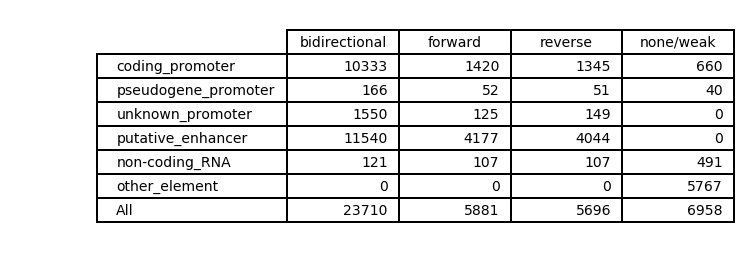

In [32]:
# Table of short cap bidirectionality statistics by type of element
def directionality_(pass_fwd, pass_rev):
    if pass_fwd and pass_rev:
        return 'bidirectional'
    elif pass_fwd:
        return 'forward'
    elif pass_rev:
        return 'reverse'
    else:
        return 'none/weak'

df_has_scap = pd.DataFrame()
df_has_scap['annot'] = df_regl['annot']
df_has_scap['directionality'] = [*map(directionality_, df_scap_fwd['scap_pass'], df_scap_rev['scap_pass'])]
df_has_scap['directionality'].value_counts()

df_ = pd.crosstab(pd.Categorical(df_has_scap['annot']), pd.Categorical(df_has_scap['directionality']), margins=True)\
.loc[config['annot'] + ['All'], ['bidirectional', 'forward', 'reverse', 'none/weak']]

fig = plt.figure(figsize=(4,2))
plt.subplot(111, frame_on=False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
pd.plotting.table(data=df_, ax=plt.gca(), loc='center left')
#plt.savefig('annot/FigA_mapping/annot_crosstab_scap.pdf', bbox_inches='tight')

2216 bidirectional promoters
5835 forward-only promoters
5707 reverse-only promoters


Text(0.962151,-0.533166,'2216 bidirectional\npromoters')

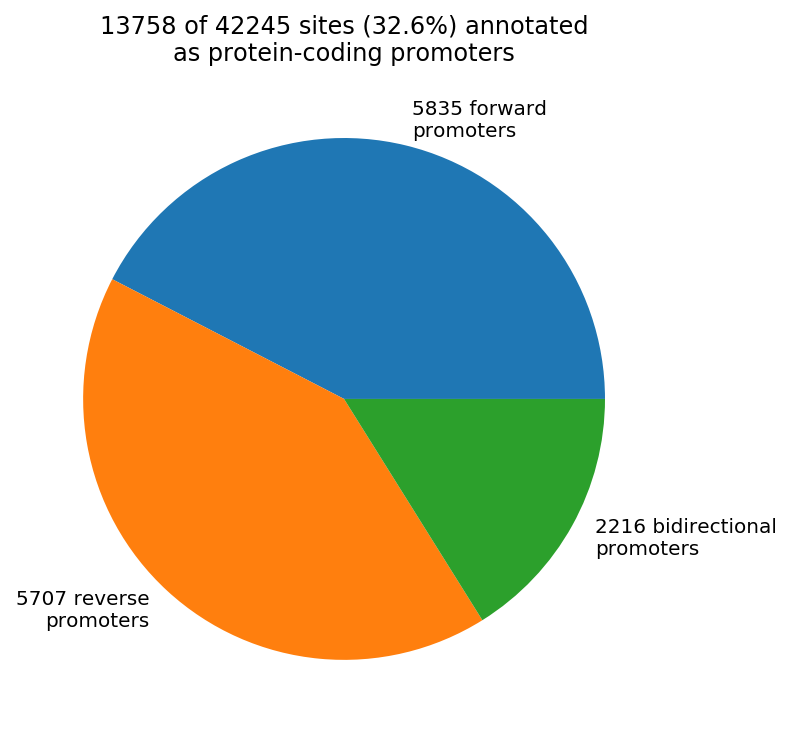

In [33]:
# Pie chart of different types of promoters
n_bid = len(df_regl.query('(annot == "coding_promoter") & (strand == ".")'))
n_fwd = len(df_regl.query('(annot == "coding_promoter") & (strand == "+")'))
n_rev = len(df_regl.query('(annot == "coding_promoter") & (strand == "-")'))
print('%d bidirectional promoters' % (n_bid))
print('%d forward-only promoters' % (n_fwd,))
print('%d reverse-only promoters' % (n_rev,))
plt.figure(figsize=(16,6)).subplots_adjust(wspace=0.4)
plt.subplot(1,2,1, aspect=1)
plt.title('%d of %d sites (%.1f%%) annotated\nas protein-coding promoters' % \
    (n_fwd + n_rev + n_bid, len(df_regl), 100 * (n_fwd + n_rev + n_bid) / float(len(df_regl)),))
plt.pie([n_fwd, n_rev, n_bid], labels=[
        '%(n_fwd)d forward\npromoters' % locals(),
        '%(n_rev)d reverse\npromoters' % locals(), 
        '%(n_bid)d bidirectional\npromoters' % locals(),
])[-1][-1]

In [34]:
# Most (82.6%) are unidirectional promoters, producing a protein-coding transcript in one direction
n_prom = sum((df_regl['annot'] == 'coding_promoter'))
n_prom_bs = sum((df_regl['annot'] == 'coding_promoter') & df_scap_fwd['scap_pass'] & df_scap_rev['scap_pass'])
print(n_prom_bs/n_prom)

m_fwd = (df_regl['annot_fwd'] == 'coding_promoter') & (df_regl['annot_rev'] != 'coding_promoter')
m_rev = (df_regl['annot_fwd'] != 'coding_promoter') & (df_regl['annot_rev'] == 'coding_promoter')
n_prom_bs_ud = sum((m_fwd | m_rev) & df_scap_fwd['scap_pass'] & df_scap_rev['scap_pass'])
print(n_prom_bs_ud/n_prom_bs)

0.751053932258
0.823091067454
